## Santander Customer Transactions predictions

#BigDataSets##HighDimensionality#DataBalancing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta  
import os
import random
import scipy as sp
from operator import attrgetter

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

import seaborn as sns; sns.set()

In [2]:
from functions import compute_mahalanobis_parts

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [4]:
import warnings
warnings.filterwarnings('ignore')

### Data Exploration

the submission contains the forecasted prices, then I merge the submission and the Test set

In [5]:
train = pd.read_csv('train.csv')
ss = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
#test = test.merge(ss, left_on = 'ID_code', right_on = 'ID_code', how = 'inner')

In [6]:
train.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3  14.9250  ...   4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  19.2514  ...  -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  
2  -6.5213   8.2675  14.7222   0.3965  
3  -2.9275  10.2922  17.9697  -8.9996  
4   3.9267   9.5031  17.9974  -8.8104  

[5 rows x 202 columns]

#### Measuring null data

Droping those that have high number of empty rows

In [7]:
def nullcalc(df,variable):
    nulls = len(df[df[variable].isna()])
    rows = len(df)
    value = round(len(df[df[variable].isna()])/len(train)*100,2)
    string =  'The column ' + variable + ' has ' + str(value) + '% of nulls'
    return string,value

In [8]:
for variable in train.columns:
    if nullcalc(train,variable)[1] > 0 :
        print(nullcalc(train,variable)[0])

seems that data is 100% complete so no nulls

<b> More Exploration

Target

In [9]:
df = train.pivot_table(index = 'target', aggfunc = 'count')[['ID_code']].reset_index()
df['total'] = df.ID_code.sum()
df = df.assign(percent = df.ID_code/df.total)

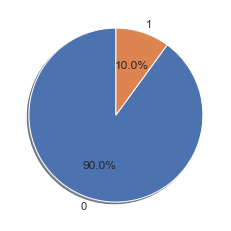

In [10]:
fig1, ax1 = plt.subplots()
ax1.pie(df.percent, labels = df.target , autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

Target will need balance

<b> variable by variable

In [11]:
def plotviolins(data,ini):
    fig, axs = plt.subplots(nrows=2, ncols=5,figsize=(27,10))
    varsuse = 5
    rows = [0,0,0,0,0,1,1,1,1,1]
    cols =[0,1,2,3,4,0,1,2,3,4]
    ini = ini

    for row,col in zip(rows,cols):

        end = ini + varsuse
        columns = list(data.columns[ini:end])
        df = data[columns + ['target'] ].melt(id_vars=['target'], value_vars = columns, var_name='Var', value_name='Value')
        sns.violinplot(ax = axs[row,col], data=df, x="Var", y="Value", hue="target",split=True, inner="quart", linewidth=1,scale="area")

        ini = end

    return plt.show()

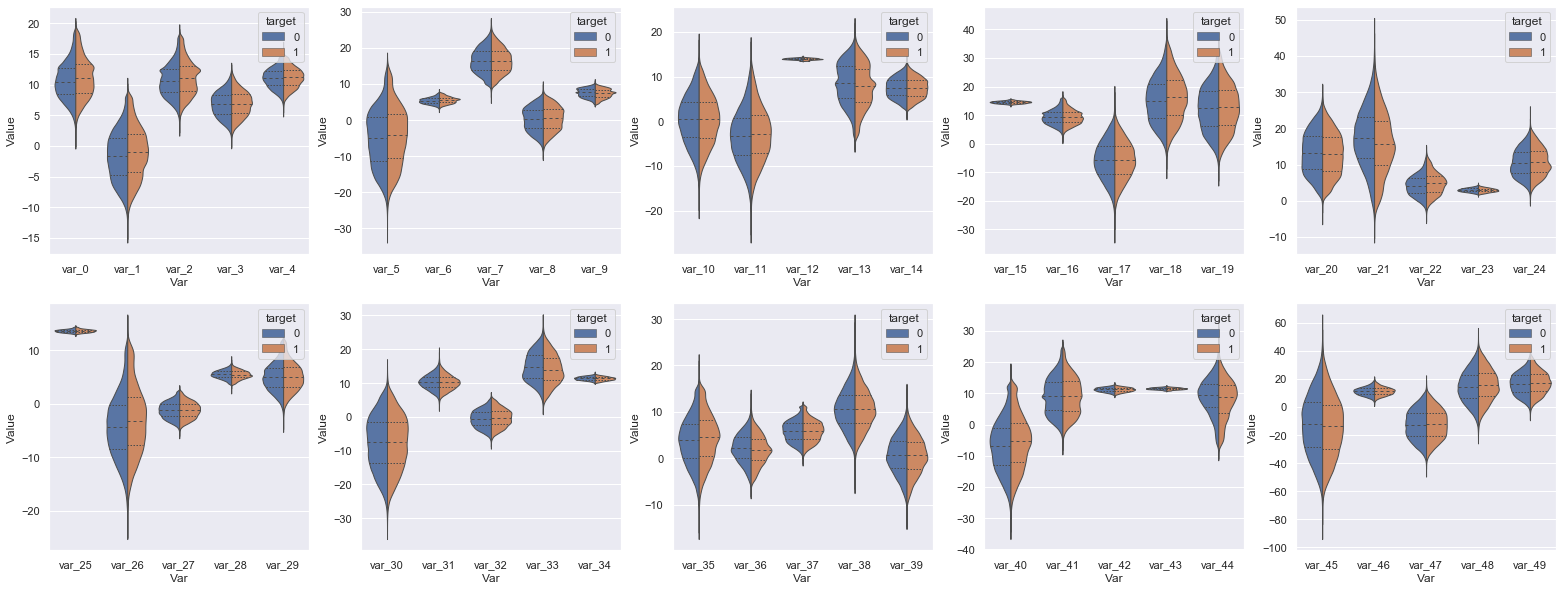

In [12]:
plotviolins(train,ini = 2)

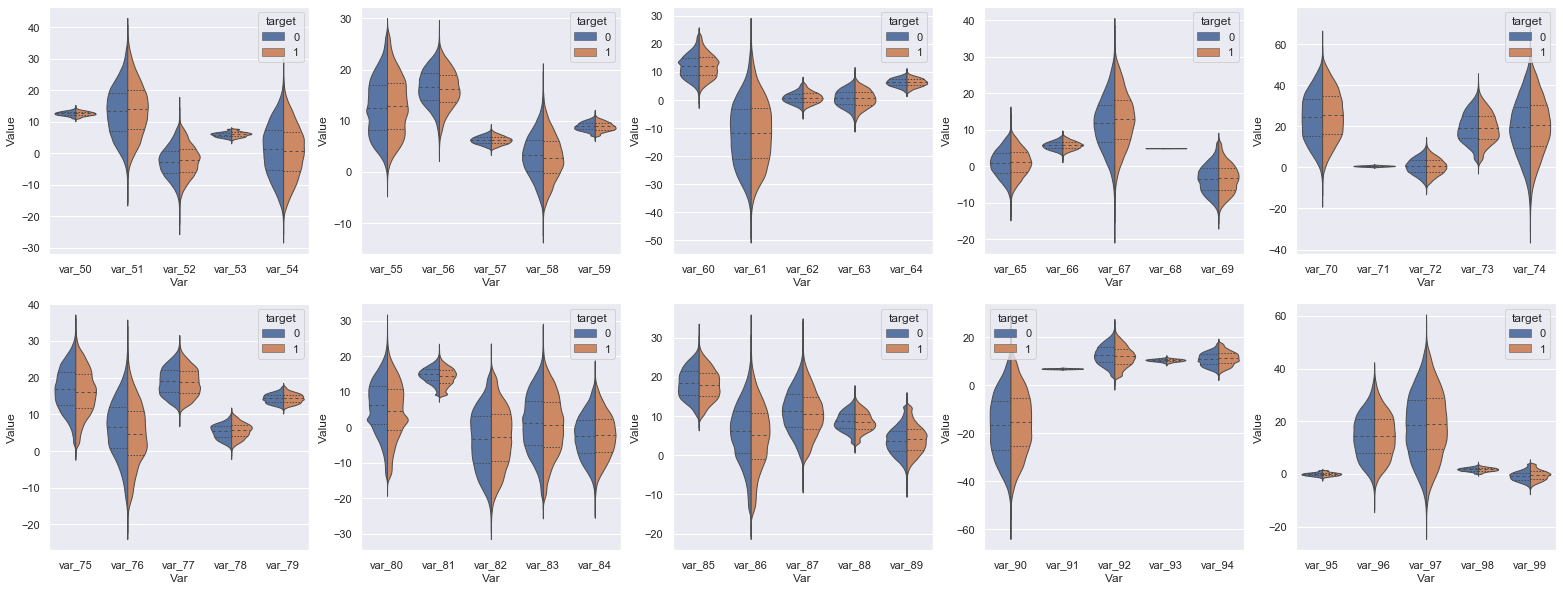

In [13]:
plotviolins(train,ini = 52)

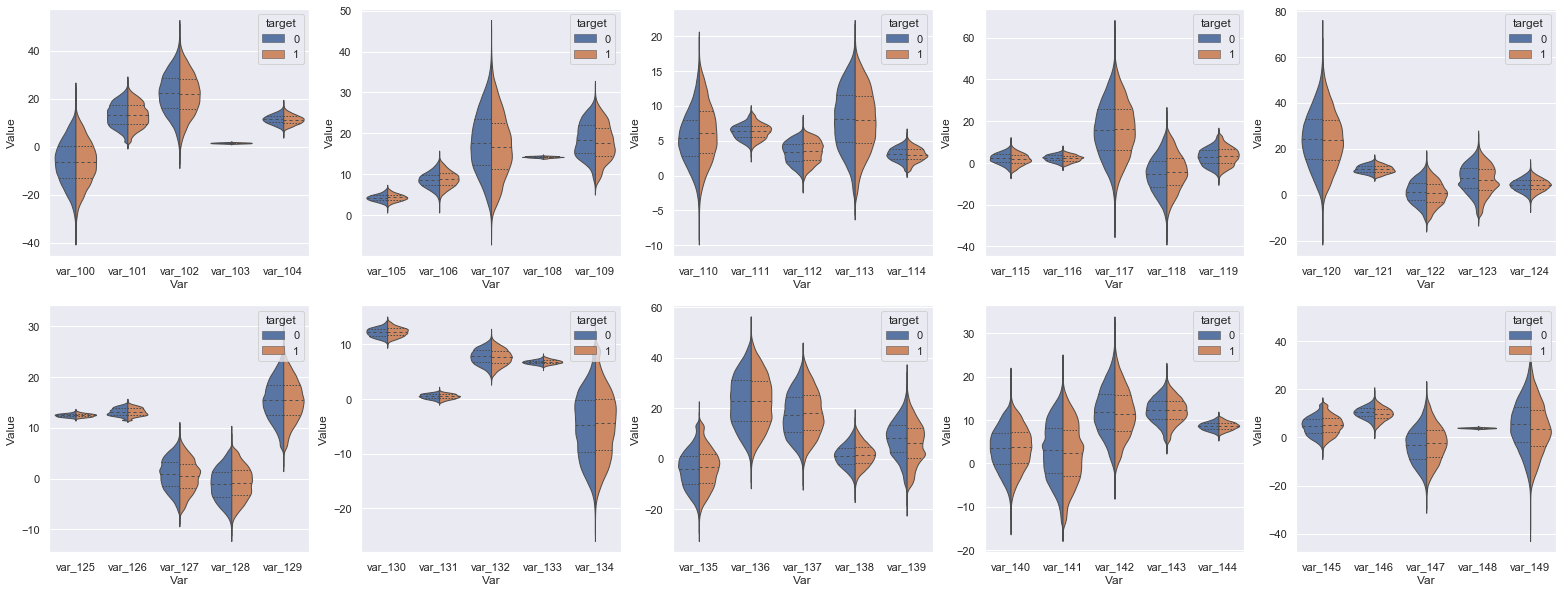

In [14]:
plotviolins(train,ini = 102)

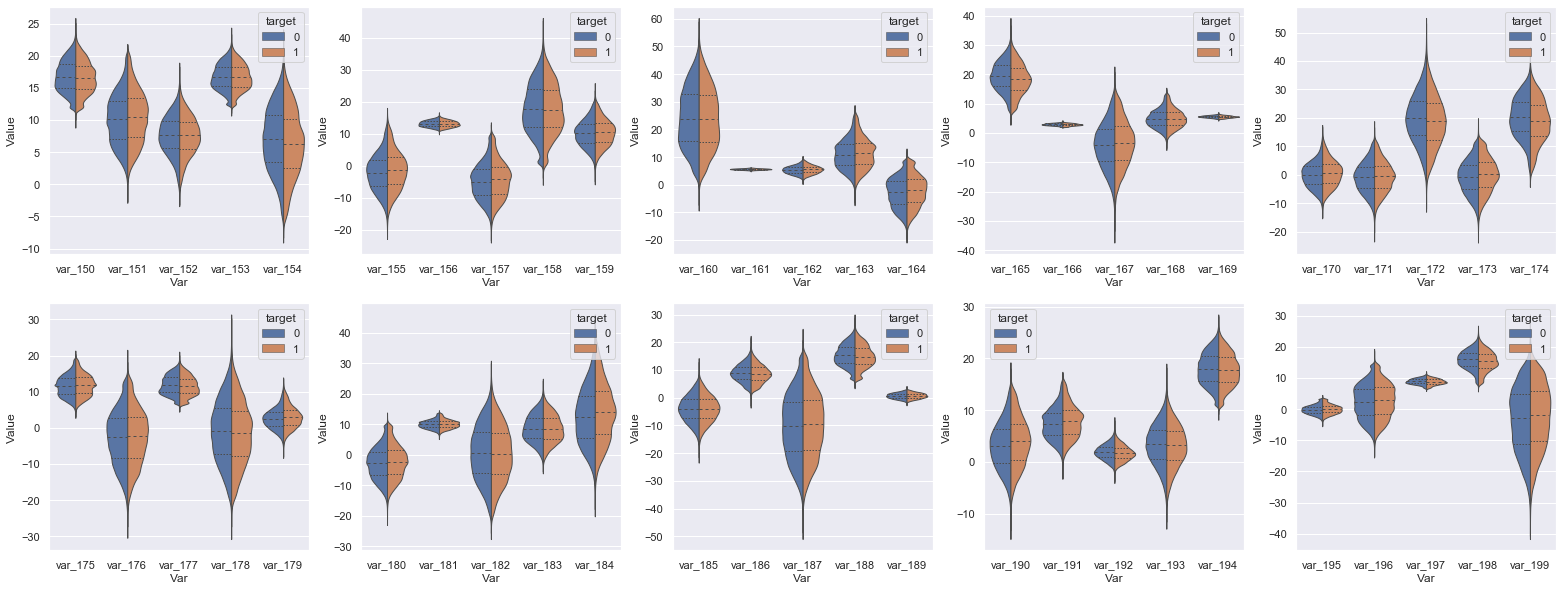

In [15]:
plotviolins(train,ini = 152)

interesting the distribution of all the variables

### Feature analysis

In [16]:
correlations = train.iloc[:,2::].corr()

finding high correlations

In [17]:
correlations

var_0     var_1     var_2     var_3     var_4     var_5     var_6  \
var_0    1.000000 -0.000544  0.006573  0.003801  0.001326  0.003046  0.006983   
var_1   -0.000544  1.000000  0.003980  0.000010  0.000303 -0.000902  0.003258   
var_2    0.006573  0.003980  1.000000  0.001001  0.000723  0.001569  0.000883   
var_3    0.003801  0.000010  0.001001  1.000000 -0.000322  0.003253 -0.000774   
var_4    0.001326  0.000303  0.000723 -0.000322  1.000000 -0.001368  0.000049   
...           ...       ...       ...       ...       ...       ...       ...   
var_195  0.002073 -0.000785 -0.001070  0.001206  0.003706 -0.001274  0.001244   
var_196  0.004386 -0.000377  0.003952 -0.002800  0.000513  0.002880  0.005378   
var_197 -0.000753 -0.004157  0.001078  0.001164 -0.000046 -0.000535 -0.003565   
var_198 -0.005776 -0.004861 -0.000877 -0.001651 -0.001821 -0.000953 -0.003025   
var_199  0.003850  0.002287  0.003855  0.000506 -0.000786  0.002767  0.006096   

            var_7     var_8     var_9  ...   var_190   var_191   var_192  \
var_0    0.002429  0.004962 -0.002613  ...  0.002752  0.000206 -0.005373   
var_1    0.001511  0.004098 -0.000832  ...  0.006627  0.003621 -0.002604   
var_2   -0.000991  0.002648 -0.001932  ...  0.000197  0.001285 -0.003400   
var_3    0.002500  0.003553 -0.000826  ...  0.000151  0.002445 -0.001530   
var_4    0.004549  0.001194 -0.000918  ...  0.001514  0.004357  0.003347   
...           ...       ...       ...  ...       ...       ...       ...   
var_195  0.001854  0.001396 -0.000868  ...  0.004571  0.000870 -0.004745   
var_196  0.001045 -0.003242  0.000052  ... -0.000847  0.002466 -0.001386   
var_197  0.003466 -0.004583  0.003701  ... -0.004974  0.000906 -0.000527   
var_198  0.000650  0.002950  0.002343  ... -0.000153 -0.000067  0.003451   
var_199 -0.001457  0.000854  0.001070  ... -0.000404  0.003595 -0.001239   

          var_193   var_194   var_195   var_196   var_197   var_198   var_199  
var_0    0.001616 -0.001514  0.002073  0.004386 -0.000753 -0.005776  0.003850  
var_1    0.001153 -0.002557 -0.000785 -0.000377 -0.004157 -0.004861  0.002287  
var_2    0.000549  0.002104 -0.001070  0.003952  0.001078 -0.000877  0.003855  
var_3   -0.001699 -0.001054  0.001206 -0.002800  0.001164 -0.001651  0.000506  
var_4    0.000813 -0.000068  0.003706  0.000513 -0.000046 -0.001821 -0.000786  
...           ...       ...       ...       ...       ...       ...       ...  
var_195 -0.003143 -0.001201  1.000000  0.002517 -0.004170 -0.000536  0.002042  
var_196 -0.005308 -0.005040  0.002517  1.000000 -0.000454  0.000253  0.000607  
var_197  0.005068  0.000884 -0.004170 -0.000454  1.000000  0.001183  0.004991  
var_198  0.001646  0.003194 -0.000536  0.000253  0.001183  1.000000 -0.004731  
var_199 -0.000552 -0.005615  0.002042  0.000607  0.004991 -0.004731  1.000000  

[200 rows x 200 columns]

In [18]:
variables = list(correlations.columns)
cutoff = 0.5
for var in variables:
    index_1 = variables.index(var)+1
    therest = variables[index_1:]
    for nextvar in therest:
        corr = abs(correlations.loc[var,nextvar])
        if corr > cutoff:
            print(var,nextvar)

fuck no high correlated variables

#### More vizs

In [19]:
def scatter_plot_test(data, frac = 0.10):
    fig, axs = plt.subplots(nrows=2, ncols=5,figsize=(27,10))
    rows = [0,0,0,0,0,1,1,1,1,1]
    cols =[0,1,2,3,4,0,1,2,3,4]

    for row,col in zip(rows,cols):
        cols = list(range(2,199))
        rand = random.choice(cols)
        var1 =list(data.columns)[rand]
        rand = random.choice(cols)
        var2 = list(data.columns)[rand]
        df = data[['target',var1,var2]].sample(frac = frac, replace = False)
        sns.scatterplot(ax = axs[row,col],data=df, x=list(df.columns)[1], y=list(df.columns)[2], hue="target")

    plt.show()

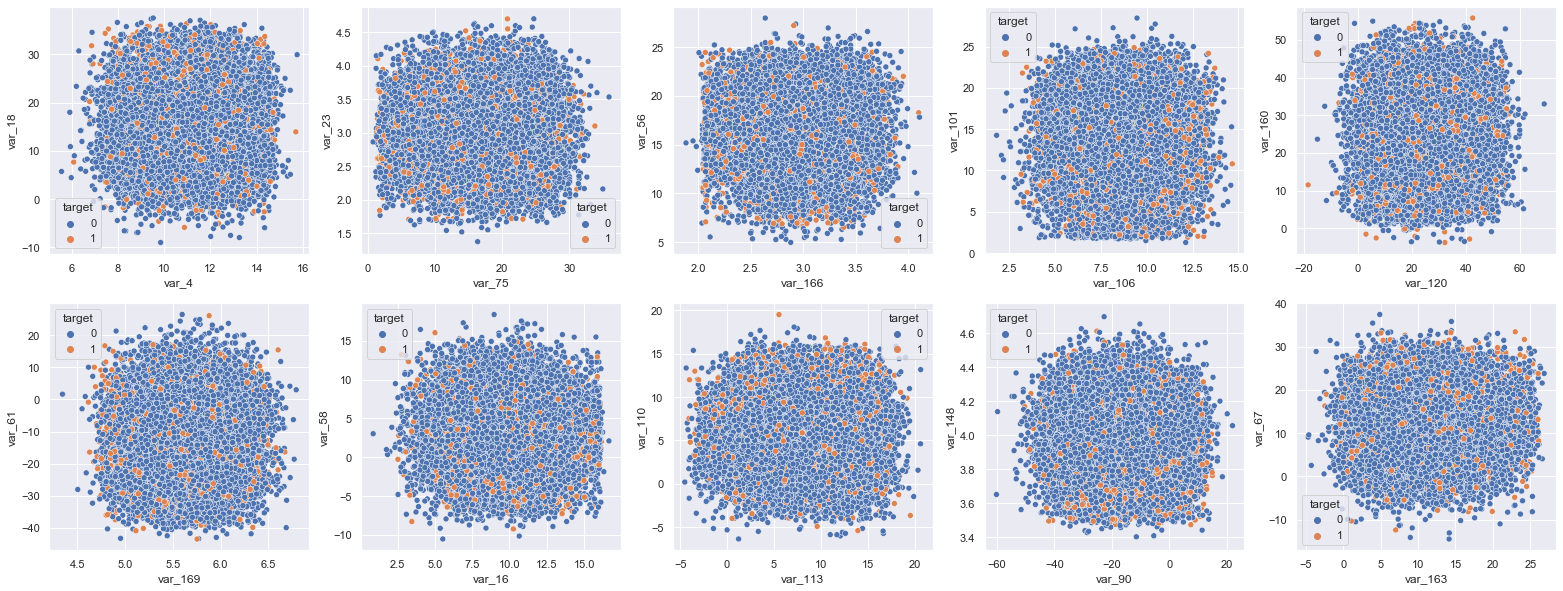

In [20]:
scatter_plot_test(data = train)

In [99]:
def scaler(dataset):
    df  = dataset.iloc[:,2:]
    scaler = StandardScaler()
    scaler.fit(df)

    dataset_scaled = scaler.transform(df)
    dataset_scaled = pd.DataFrame(dataset_scaled, columns = df.columns)
    df_result = pd.concat([dataset.iloc[:,0:2],dataset_scaled], axis = 1)
    return df_result, scaler

In [22]:
train_scaled, scaler_train = scaler(train)

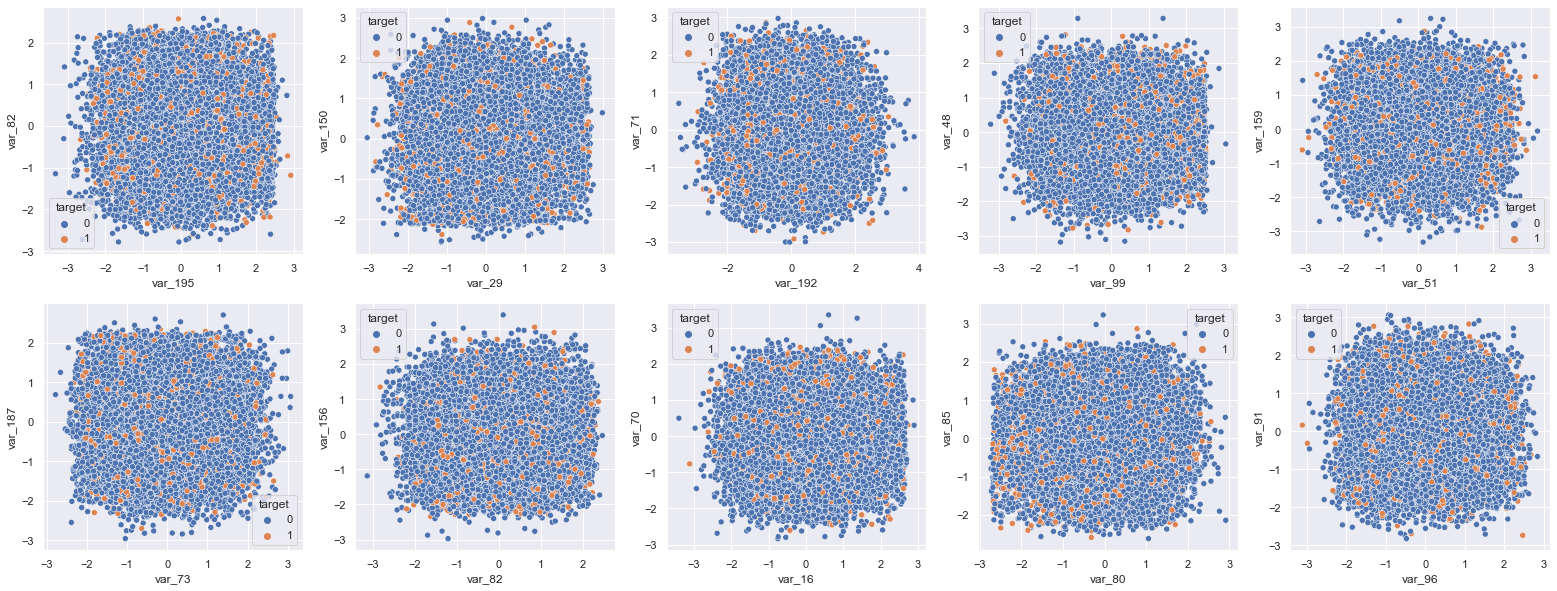

In [23]:
scatter_plot_test(data = train_scaled)

In [11]:
def threeD_plot(dataset,variables,fraq = 0.10):
    variables = variables + ["target"]
    fig = plt.figure(figsize=(13,13))
    df  = dataset.sample(frac = fraq, replace = False)
    ax = Axes3D(fig)
    categories = list(df["target"].unique())
    categories.sort()
    for category in categories:
        df_plot = df[df["target"] == category]
        countx = len(df_plot)
        alpha = 0.7
        if category != 1:
            alpha = 0.4
        sc = ax.scatter(df_plot[variables[0]], df_plot[variables[1]], df_plot[variables[2]], marker='o', alpha=alpha, label= f'{category}-{countx}' )
        
    ax.legend()
    ax.set_xlabel(variables[0])
    ax.set_ylabel(variables[0])
    ax.set_zlabel(variables[0])
    ax.set_facecolor("grey")
    plt.show()

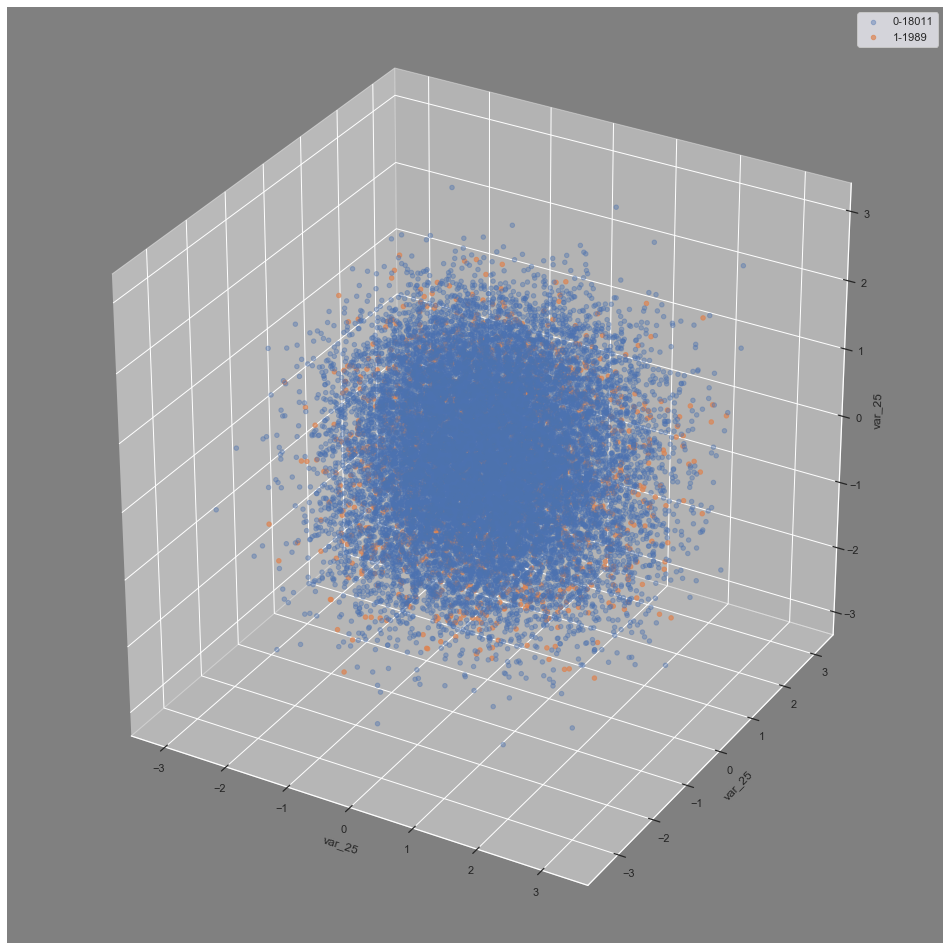

In [25]:
threeD_plot(train_scaled,['var_25', 'var_17', 'var_113'])

### Testing mahalanobis distance for espherical check

In [45]:
numerical_features =['var_25', 'var_17', 'var_113']  #,'var_4','var_54','var_98','var_73'

In [46]:
train_dataset = train[ ['target'] + numerical_features]

means_train = np.mean(train_dataset[numerical_features])  ### Save this , over not scalled
cov_train = np.cov(train_dataset[numerical_features].T) ### Save thisnot, over not scalled

In [47]:
train_dataset_distance = compute_mahalanobis_parts(train_dataset, numerical_features, 10000,[True,True], means_train, cov_train )
train_dataset_scaled, scalerx = scaler(train_dataset_distance)

In [108]:
def mahalanobis(x=None, data=None,cov_mu = [False,False], cov=None, mu = None):
    if cov_mu[0] == False:
        cov = np.cov(data.values.T)
    elif cov_mu[0] == True:
        cov = cov
        
    if cov_mu[1] == False:
        x_mu = x - np.mean(data)
    elif cov_mu[1] == True:
        x_mu = x - mu

        
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return mahal.diagonal()

In [55]:
df = train_dataset_scaled[["target"] + numerical_features + ['mahalanobis']].sample(frac = 0.10, replace = False).copy()

In [50]:
def threeD_plot_mahalanobis(dataset,variables):
    variables = variables + ["target"]
    fig = plt.figure(figsize=(13,13))
    ax = Axes3D(fig) 
   
    ax.scatter(dataset[variables[0]], dataset[variables[1]], dataset[variables[2]], c = dataset['mahalanobis'], marker='o')

    ax.set_xlabel(variables[0])
    ax.set_ylabel(variables[0])
    ax.set_zlabel(variables[0])
    ax.set_facecolor("grey")
    plt.show()

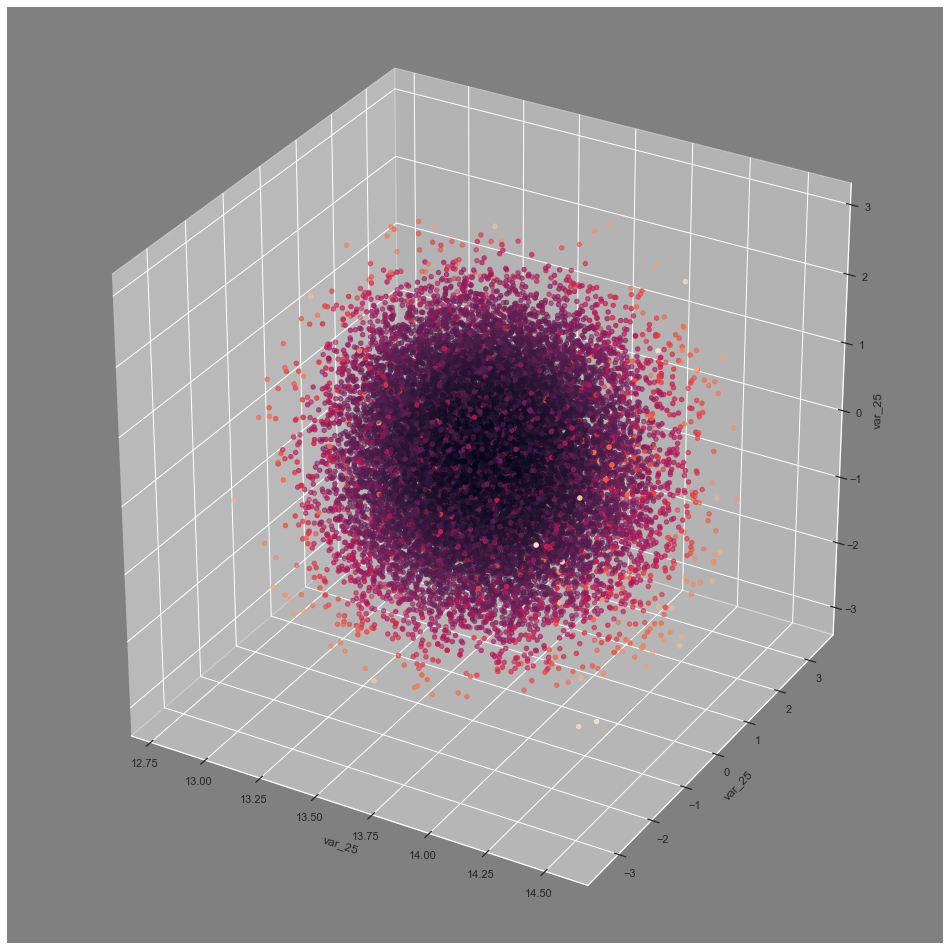

In [56]:
threeD_plot_mahalanobis(df,numerical_features)

In [112]:
def mahalanobis_vector_plot(data):
    df = data.copy()
    df = df.sort_values('mahalanobis').reset_index(drop = True)
    fig = plt.figure(figsize=(10,7))
    plt.scatter(df.index, df['mahalanobis'],marker='o')
    plt.xlabel('order')
    plt.ylabel('Mahalanobis distance')
    fig.show()

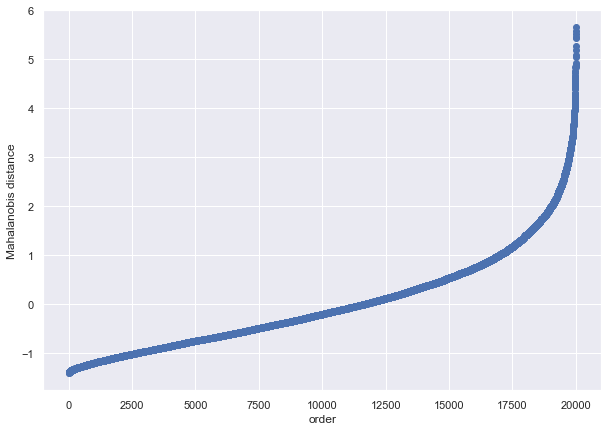

In [57]:
mahalanobis_vector_plot(df)

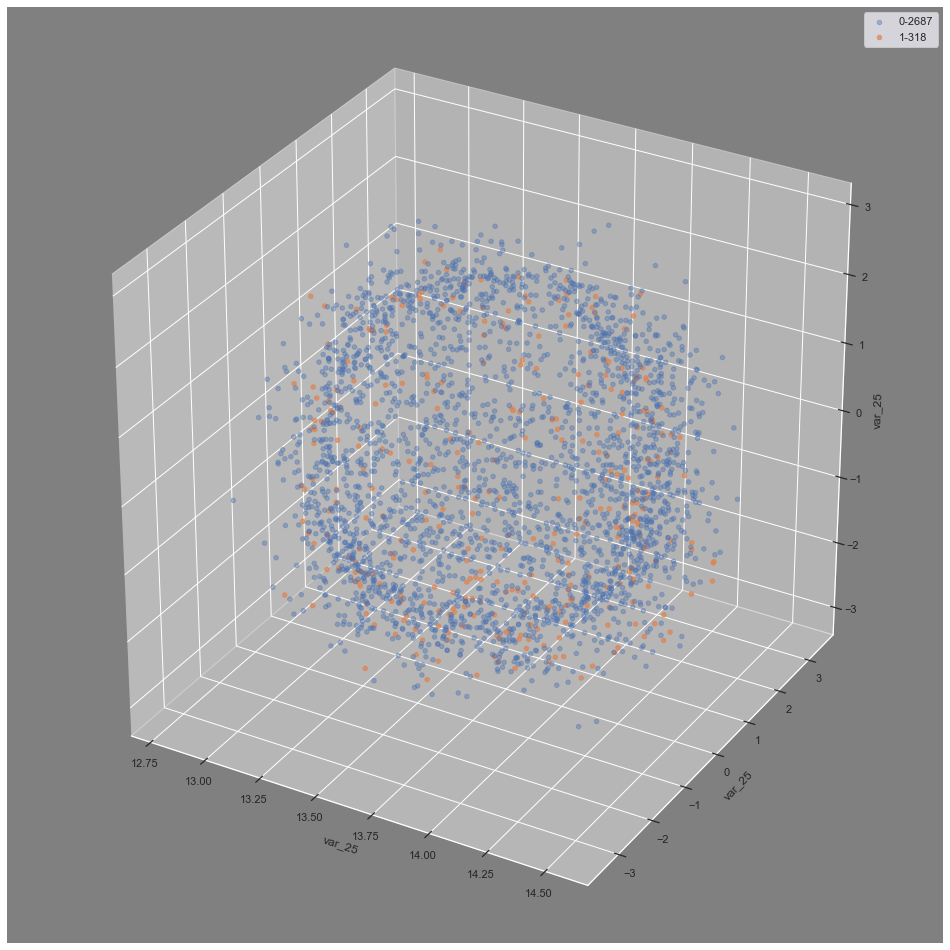

In [65]:
threeD_plot(df[(df['mahalanobis'] > 1)],numerical_features, fraq = 1.00)

In [70]:
df['cut_distance'] = pd.cut(df['mahalanobis'], bins=10, labels = range(0,10))

In [112]:
df_pivot = df.pivot_table(index = ['cut_distance','target'] , values = 'mahalanobis', aggfunc = 'count').fillna(0).reset_index(drop = False).rename(columns = {1: 'true', 0: 'false'})
df_pivot['total'] = df_pivot.groupby('cut_distance')['mahalanobis'].transform(np.sum)
df_pivot = df_pivot.assign(percentage = df_pivot.mahalanobis/df_pivot.total*100 )

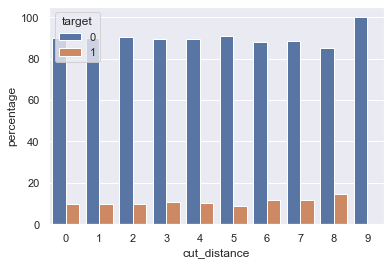

In [117]:
sns.barplot(x="cut_distance", y="percentage", data=df_pivot, hue="target")

#### Testing area countings

In [7]:
def counting_area(data, column, bins = 30):
    var = data[column]
    df['bin'] =  pd.cut(var, bins= bins)

    data[f'count{column}'] = data.groupby('bin')['target'].transform(lambda x: x[x == 1].count())
    data = data.drop(columns = 'bin')
    return data

In [8]:
df = train[['target','var_0','var_1','var_2']].copy()
df = counting_area(data = df, column = 'var_0', bins = 25)
df = counting_area(data = df, column = 'var_1', bins = 25)
df = counting_area(data = df, column = 'var_2', bins = 25)

In [9]:
df.pivot_table(index = ['countvar_0','countvar_1','countvar_2'], columns = 'target', values = 'var_0', aggfunc = 'count').reset_index().sort_values(1, ascending = False).head()

target  countvar_0  countvar_1  countvar_2      0     1
7998          1869        1790        2080  147.0  27.0
7970          1869        1761        1580  111.0  22.0
7995          1869        1790        1622  122.0  21.0
7112          1736        1761        2080  144.0  20.0
7908          1869        1616        1622  106.0  20.0

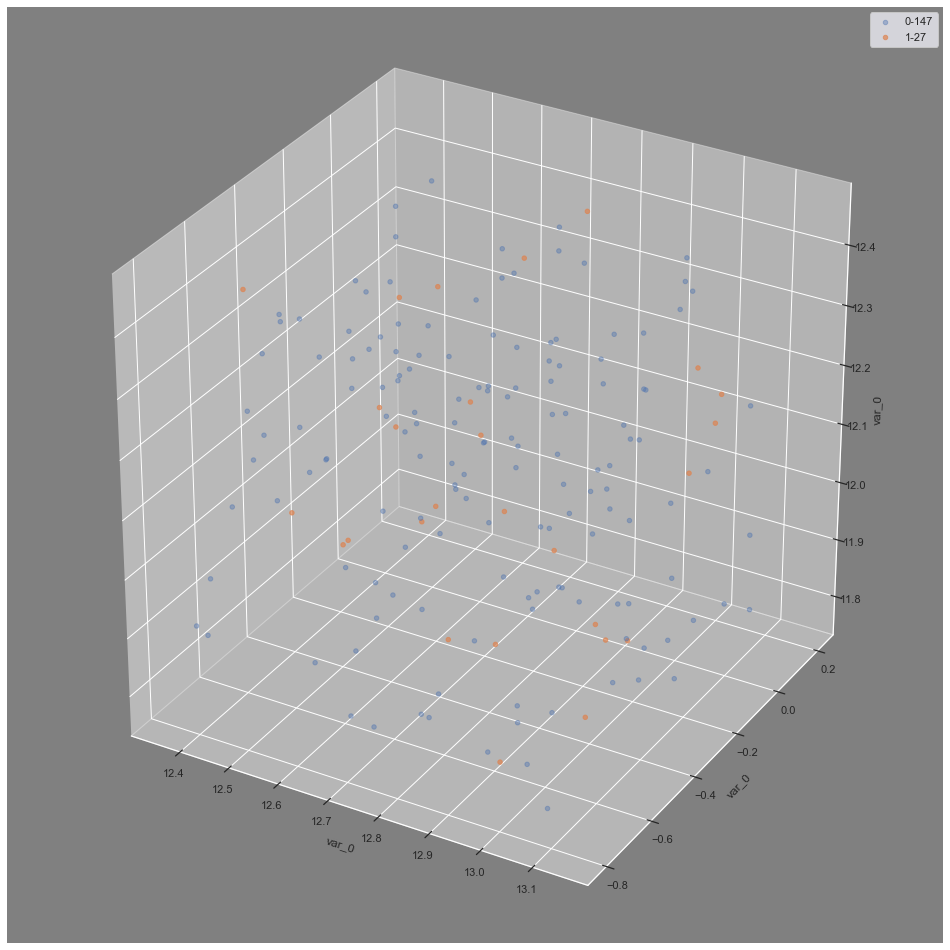

In [12]:
threeD_plot(df[(df['countvar_0'] == 1869) & (df['countvar_1'] == 1790) & (df['countvar_2'] == 2080)],['var_0','var_1','var_2'], fraq = 1.00)

In [52]:
df = train[['target','var_0','var_1','var_2']].copy()

In [53]:
def get_dictionary_count_lables(data,variables,bins):
    labels_dictionary = dict()

    for column in variables:
        high_limits = list(pd.cut(data[column], bins= bins).map(attrgetter('right')).astype(float).sort_values().unique())
        low_limits = list(pd.cut(data[column], bins= bins).map(attrgetter('left')).astype(float).sort_values().unique())
        labels_list = list()
        ## Geting the labels
        for low,high in zip(low_limits, high_limits):
            countx = len(data[(data[column] >= low) & (data[column] <= high) & (data.target == 1)] )
            labels_list.append(countx)

        labels_dictionary[column] = {'low': low_limits, 'high': high_limits, 'label': labels_list}
    return labels_dictionary

In [54]:
bins = 20
variables = ['var_1', 'var_2']
data = df
labels_counting = get_dictionary_count_lables(data, variables, bins)

In [62]:
def count_encoding(data, dictionary_lables, variables):
    data_result = data.copy()
    for variable in variables:
        lowers = dictionary_lables[variable]['low']
        highers = dictionary_lables[variable]['high']
        labels = dictionary_lables[variable]['label']
        data_result[f'count{variable}'] = 0
        for low,high,label in zip(lowers,highers,labels):
            data_result[f'count{variable}'] = np.where((data_result[variable] >= low) & (data_result[variable] <= high), label, data_result[f'count{variable}'] )
    return data_result

In [63]:
count_encoding(data, labels_counting, variables)

target    var_0   var_1    var_2  countvar_1  countvar_2
0            0   8.9255 -6.7863  11.9081        1264        2484
1            0  11.5006 -4.1473  13.8588        1627        1450
2            0   8.6093 -2.7457  12.0805        1991        2484
3            0  11.0604 -2.1518   8.9522        2156        1974
4            0   9.8369 -1.4834  12.8746        2156        2040
...        ...      ...     ...      ...         ...         ...
199995       0  11.4880 -0.4956   8.2622        2256        1974
199996       0   4.9149 -2.4484  16.7052        1991         551
199997       0  11.2232 -5.0518  10.5127        1548        1945
199998       0   9.7148 -8.6098  13.6104         793        1450
199999       0  10.8762 -5.7105  12.1183        1548        2484

[200000 rows x 6 columns]

### Insights

Data:
* no clear trend

thanks to MD, Augmentation strategy
* in concentrated places
* in empty places where low concentration of blus
* sections with possible partition thank to bin counting

### Augmentation Techniques

In [100]:
seed = 158
validation_dataset = train.sample(frac = 0.25, replace = False, random_state = seed).reset_index(drop = True)
validation_dataset = validation_dataset.copy()
train_dataset = train[~train.index.isin(validation_dataset.index)].reset_index(drop = True)

In [101]:
train_dataset_scaled, _ = scaler(train_dataset)

In [104]:
numerical_features = ['var_4','var_12','var_46','var_78','var_81','var_110','var_152','var_175','var_183','var_199']

In [105]:
def compute_mahalanobis_parts(data,numerical_features, chunk_size, cov_mu, mu, cov):
    
    chunks = list()
    num_chunks = len(data) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(data[i*chunk_size:(i+1)*chunk_size])
    
    treated_dfs = list()
    for chunk in chunks:
        chunk['mahalanobis'] = mahalanobis( x=chunk[numerical_features], data=chunk[numerical_features], cov_mu = cov_mu, mu = mu, cov = cov)
        treated_dfs.append(chunk)
    result_df = pd.concat(treated_dfs)
    #return chunks
    return result_df

In [106]:
train_dataset_scaled = train_dataset_scaled[ ['target'] + numerical_features]

means_train = np.mean(train_dataset_scaled[numerical_features])  ### Save this
cov_train = np.cov(train_dataset_scaled[numerical_features].T) ### Save this

In [109]:
train_dataset_scaled = compute_mahalanobis_parts(train_dataset_scaled, numerical_features, 10000,[True,True], means_train, cov_train )

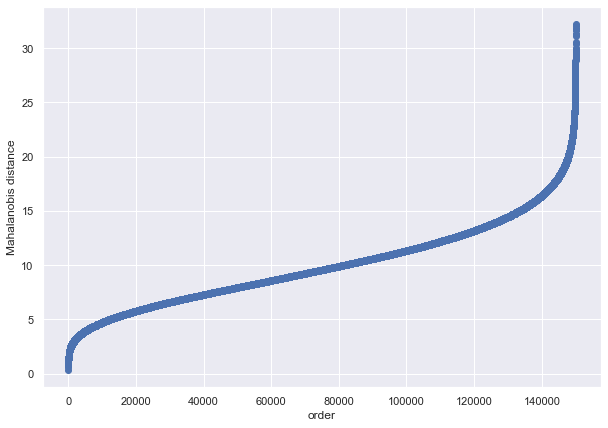

In [113]:
mahalanobis_vector_plot(train_dataset_scaled)

3 sections of train or input data using the mahalanobis distance

In [114]:
train_section_1 = train_dataset_scaled[train_dataset_scaled.mahalanobis > 15]
train_section_2 = train_dataset_scaled[(train_dataset_scaled.mahalanobis > 9) & (train_dataset_scaled.mahalanobis <= 15)]
train_section_3 = train_dataset_scaled[train_dataset_scaled.mahalanobis <= 9]

In [115]:
def normal_augmentation(data, columns, n, pop_mean, pop_cov ,range_distance = [None,None], label_target = 2, rate = 0):
    calc = 0
    var_limits = dict()
    for var in columns:
        var_limits[var] = {'mu': np.mean(data[var]),'std': np.std(data[var])}
    new_data = list()
    while calc < n:
        data_dict = dict()
        data_dict['target'] = label_target
        for var in columns:
            mu, std = var_limits[var]['mu'], var_limits[var]['std'], 
            value = np.random.normal(mu, std*(1 + rate), 1)[0]
            data_dict[var] = value
        data = pd.DataFrame(data_dict,index = [calc])
        data['mahalanobis'] = mahalanobis( x=data[columns], data=data[columns], cov_mu = [True,True], mu = pop_mean, cov = pop_cov)
        if data['mahalanobis'].values > range_distance[0] and data['mahalanobis'].values < range_distance[1]:
            new_data.append(data)
            calc = calc + 1
    new_data = pd.concat(new_data)
    return new_data

In [116]:
def concentrated_augmentation(data, columns, n, category, label_target = 3, rate = 0.015):
    data_selection = data[data.target == category]
    lenght = len(data_selection)
    new_data_result = list()
    for i in range(n):
        new_data_dict = dict()
        new_data_dict['target'] = label_target
        index = np.random.randint(low = 0, high=lenght, size=1)[0]
        data_dict = data_selection.iloc[index,:].copy().to_dict()
        for var in columns:
            q75, q25 = np.percentile(data_selection[var], [75 ,25])
            iqr = q75 - q25
            dist_param = iqr * rate
            dist = np.random.uniform(-dist_param,dist_param,1)[0]

            new_value = data_dict[var] + dist
            new_data_dict[var] = new_value
            #print(f'var{var} before {data_dict[var]} new:{new_data_dict[var]}')
        new_data_dict['mahalanobis'] = data_dict['mahalanobis']
        #print(data_dict,new_data_dict)
        new_data_df = pd.DataFrame(new_data_dict, index = [i])
        new_data_result.append(new_data_df)
    new_data_result = pd.concat(new_data_result)
    return new_data_result

In [117]:
train_section_1.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    13926
1     2650
Name: mahalanobis, dtype: int64

In [118]:
aug_normal = normal_augmentation(data = train_section_1 , columns = numerical_features, n = 1600,
                          pop_mean = means_train, pop_cov = cov_train,range_distance = [15,35], label_target = 2, rate = 0)

In [119]:
aug_normal2 = normal_augmentation(data = train_section_1 , columns = numerical_features, n = 1600,
                          pop_mean = means_train, pop_cov = cov_train,range_distance = [15,35], label_target = 6, rate = 0.5)

In [120]:
aug_conditioned_1 = concentrated_augmentation(data = train_section_1, columns = numerical_features, n = 1800, category = 1)

In [121]:
aug_conditioned_2 = concentrated_augmentation(data = aug_normal, columns = numerical_features, n = 800, category = 2, label_target = 4)

In [122]:
train_section_1_aug = pd.concat([train_section_1,aug_normal2])

In [123]:
train_section_1_aug.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    13926
1     2650
6     1600
Name: mahalanobis, dtype: int64

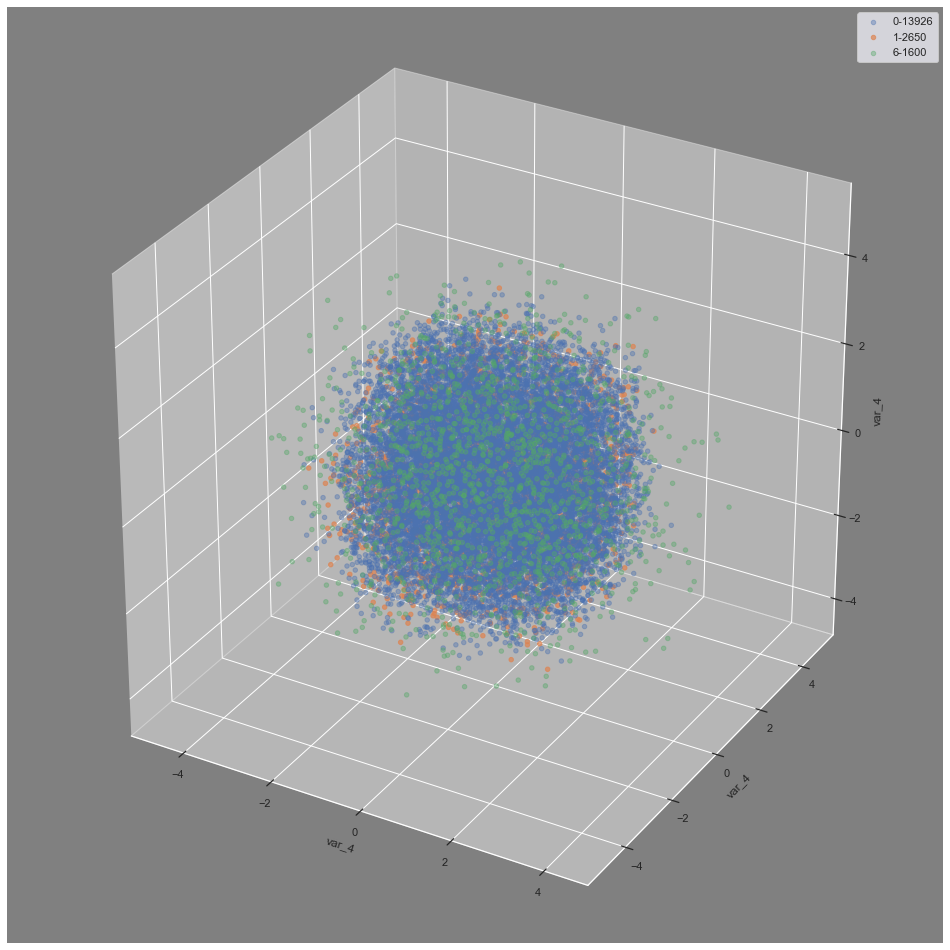

In [124]:
threeD_plot(train_section_1_aug,['var_4', 'var_12', 'var_46'], fraq = 1.0)

### Feature Selection

In [163]:
seed = 158
validation_dataset = train.sample(frac = 0.25, replace = False, random_state = seed).reset_index(drop = True)
validation_dataset = validation_dataset.copy()
train_dataset = train[~train.index.isin(validation_dataset.index)].reset_index(drop = True)

In [164]:
train_dataset_scaled, _ = scaler(train_dataset)

In [165]:
numerical_features = list(train_dataset_scaled.columns[2:-1])

In [166]:
train_dataset_scaled = train_dataset_scaled[ ['target'] + numerical_features]

means_train = np.mean(train_dataset_scaled[numerical_features])  ### Save this
cov_train = np.cov(train_dataset_scaled[numerical_features].T) ### Save this

In [167]:
train_dataset_scaled = compute_mahalanobis_parts(train_dataset_scaled, numerical_features, 10000,[True,True], means_train, cov_train )

In [168]:
train_dataset_scaled.describe().mahalanobis

count   150000.0000
mean       198.9987
std         17.7793
min        129.6224
25%        186.7530
50%        198.3966
75%        210.5880
max        292.0286
Name: mahalanobis, dtype: float64

In [169]:
train_dataset_scaled.pivot_table(index = 'target', aggfunc = 'count')['var_2']

target
0    134860
1     15140
Name: var_2, dtype: int64

In [170]:
augmentation = concentrated_augmentation(data = train_dataset_scaled, columns = numerical_features, n = 10000, category = 1)

In [176]:
full_train_dataset = pd.concat([train_dataset_scaled, augmentation.replace({'target': {3: 1}})])

In [178]:
full_train_dataset.head()

target   var_0   var_1   var_2   var_3   var_4   var_5   var_6   var_7  \
0       0  1.3015  1.5065 -0.3790 -1.8482  1.4192  1.2396  1.7582 -0.2723   
1       0 -1.4959  0.6024 -1.1238  0.7365  0.8208  1.1127  0.1414  0.4616   
2       0  1.3691  0.6309  0.3540  0.9707 -0.0357 -0.9038 -0.5826  0.9138   
3       0  2.6053 -0.1928  1.1704  1.7885  1.7800 -0.3798  0.9966  0.3441   
4       0 -0.3842 -0.6800 -0.4643 -0.0799  0.1409  0.1724  0.2129  0.1225   

    var_8  ...  var_190  var_191  var_192  var_193  var_194  var_195  var_196  \
0  1.0656  ...   0.9884   0.6951   1.7971   0.3284   0.4883   2.2789  -0.4309   
1  1.4510  ...  -0.2957   2.3892  -0.6465   1.3152   0.0057  -0.3151   0.8422   
2  0.2585  ...   1.0706   2.2734  -1.4717  -0.0153   0.0318  -0.3946   0.1392   
3 -0.5140  ...  -1.3071   0.8415  -0.3616  -0.1504   2.3544   0.2615   0.8653   
4 -0.5116  ...   2.3145   0.9790  -0.2638  -0.5994   0.7093   2.2570   0.0520   

   var_197  var_198  mahalanobis  
0  -0.3056  -0.4394     198.5021  
1   0.6868   0.8207     184.5021  
2   0.1414  -0.5126     195.0754  
3   0.4428   0.4044     191.8791  
4   0.0091   1.1518     198.2335  

[5 rows x 201 columns]

In [179]:
X_train = full_train_dataset[numerical_features + ['mahalanobis']]
Y_train = full_train_dataset['target']

In [191]:
knneig = RandomForestClassifier(n_estimators=200, max_depth = 120, min_samples_split = 10)

knneig_selector = SelectFromModel(knneig, max_features=30, )
knneig_selector.fit(X_train, Y_train)

SelectFromModel(estimator=RandomForestClassifier(max_depth=120,
                                                 min_samples_split=10,
                                                 n_estimators=200),
                max_features=30)

In [192]:
knneig_support = knneig_selector.get_support()
knneig_feature = X_train.loc[:,knneig_support].columns.tolist()
print(str(len(knneig_feature)), 'selected features')

30 selected features


In [ ]:
knneig_feature = ['var_0','var_1', 'var_2','var_6','var_12','var_13','var_21','var_22','var_26','var_34',
                  'var_40','var_53','var_76','var_78','var_80','var_81','var_99','var_109','var_110','var_133',
                  'var_139','var_146','var_148','var_164','var_165','var_166','var_174','var_190','var_198','mahalanobis']

### General Conclusions

* 30 features are taken using random forest and recursive feature selection
* mahalanobis and bin counting distance is used to get esperical partitiions of the data
* a new train csv with the mahalanobis distance is given
* functions of augmentations are given